# Truncated Taylor series

This jupyter notebook provides a simple ipywidgets app to demonstrate the Taylor polynomial approximation of a function.

In [1]:
%matplotlib notebook

# import external modules, matplotlib for plotting, numpy for linear algebra, 
# sympy for symbolic calculations and ipywidgets for the GUI elements
import matplotlib.pyplot as plt
import numpy as np

from sympy import *
from sympy.parsing.sympy_parser import parse_expr
from sympy.abc import x

import ipywidgets as widgets

In [2]:
# Define some helpful functions

def evaluate_shifted_polynomial(coeffs, x0, degree, xs):
    """
    Given an array coeffs of symbolic expressions in x, where len(coeffs) >= degree, evaluate the shifted 
    polynomial 
    
      f(x) = sum( coeffs[k](x)*(x-x0)**k)
      
    where the sum goes over k from 0 to degree. This is used to evaluate the Taylor polynomial, where the coefficients
    coeffs[k] = (k! * df/dk(x0)) are precomputed.
    """
    ys = np.ones(np.shape(xs))*coeffs[0].subs(x, x0)
    xs_shift = xs - np.ones(np.shape(xs))*x0
    for k in range(1, degree + 1):
        ys = ys + coeffs[k].subs(x, x0)*xs_shift**k
    return ys

# we need helper functions to interactively update horizontal and vertical lines in a plot
# https://stackoverflow.com/questions/29331401/updating-pyplot-vlines-in-interactive-plot

def update_vlines(*, h, x, ymin=None, ymax=None):
    """
    If h is a handle to a vline object in a matplotlib plot, this function can be used to update x, ymin, ymax
    """
    seg_old = h.get_segments()
    if ymin is None:
        ymin = seg_old[0][0, 1]
    if ymax is None:
        ymax = seg_old[0][1, 1]

    seg_new = [np.array([[x, ymin],
                        [x, ymax]]),]

    h.set_segments(seg_new)
    
def update_hlines(*, h, y, xmin=None, xmax=None):
    """
    If h is a handle to a hline object in a matplotlib plot, this function can be used to update y, xmin, xmax
    """
    seg_old = h.get_segments()
    if xmin is None:
        xmin = seg_old[0][0, 0]
    if xmax is None:
        xmax = seg_old[0][1, 0]

    seg_new = [np.array([[xmin, y],
                         [xmax, y]]),]

    h.set_segments(seg_new)

<IPython.core.display.Javascript object>


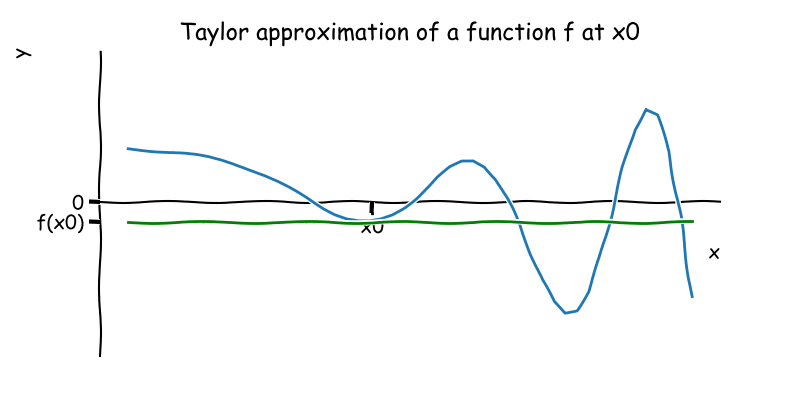

In [3]:
##############################
# Define some initial values #
##############################


# Define the function f, the evaluation point x0 and degree of the Taylor polynomial

f           = 25 + exp(x)*sin(x**2) - 10*x
x0_init     = 2.3
degree_init = 0
degree_max  = 10

# The following variables control the x and y ranges as well as the resolution of the plot
xmin_init = 1
xmax_init = 4
ymin_init = -50
ymax_init = 50
res_init  = 50

# Most of the above variables can be modified interactively using widgets

##################################
# Create the interactive widgets #
##################################

# Control the visibility of the Taylor polynomial in the plot
visible = widgets.ToggleButton(
    value=True,
    description='Toggle visibility of Taylor polynomial',
    disabled=False,
    tooltip='Toggle visibility of Taylor polynomial',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

# Create a slider for the evaluation point x0
x0 = widgets.FloatSlider(
    value=x0_init,
    min=xmin_init,
    max=xmax_init,
    step=0.1,
    description='x0',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

# create a slider for the degree of the Taylor polynomial
degree = widgets.IntSlider(
    value=degree_init,
    min=0,
    max=degree_max,
    description='degree',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)

# Create a text box for the function expression
func = widgets.Text(
    description="Function", 
    value=str(f))

# Create sliders for the x and y ranges of the plot
xmin = widgets.FloatText(
    value=xmin_init,
    description='xmin',
    disabled=False
)
xmax = widgets.FloatText(
    value=xmax_init,
    description='xmax',
    disabled=False
)
ymin = widgets.FloatText(
    value=ymin_init,
    description='ymin',
    disabled=False
)
ymax = widgets.FloatText(
    value=ymax_init,
    description='ymax',
    disabled=False
)

# x0 slider limits depend on xmin and xmax
def update_x_range(*args):
    """
    Sets the slider limits of the x0 slider to the minimum and maximum values of the x-range.
    """
    x0.min = xmin.value
    x0.max = xmax.value
xmin.observe(update_x_range, 'value')
xmax.observe(update_x_range, 'value')

# cache coefficents of the Taylor polynomial in an array, and add an observer for the function expression text box.
# Whenever the input in the text box changes, the symbolic representations of the coefficients of the Taylor polynomial are 
# updated. This way they don't have to be recomputed each time the x0 and degree sliders are used, which will result in a
# better overall performance
coefficients = [0 for k in range(0, degree_max+1)]
def update_coefficients(*args):
    """
    stores symbolic representations of the coefficients k! * df/dk(x0) of the Taylor polynomial in an array from the 
    outer scope.
    
    This is used to cache the derivative calculation for better performance, when evaluating the Taylor polynomial
    """    
    
    coefficients[0] = parse_expr(func.value)
    fac = 1
    for k in range(1, degree_max + 1):
        coefficients[k] = diff(coefficients[k-1]*fac, x)/(fac*k)
        fac = fac*k

#precalculate the coeffients for the initially set variables
update_coefficients()
# make sure the coefficients are updated each time the value of the function text box changes
func.observe(update_coefficients, 'value')

# organize all widgets into two tabs
tab = widgets.Tab()
tab.children = [
    widgets.VBox([
        visible, 
        x0, 
        degree
    ]),
    widgets.VBox([
        func,
        widgets.Label("Display options"),
        widgets.HBox([
          xmin,
          xmax
        ]),
        widgets.HBox([
          ymin,
          ymax
        ])
    ])
]
tab.set_title(0, f"Taylor polynomial")
tab.set_title(1, f"Advanced")
tab.set_title(2, "Log")

#############################################
# Define the function that updates the plot #
#############################################

def update_plot(visible=True, 
                function=f, 
                x0=x0_init, 
                degree=degree_init, 
                xmin=xmin_init,
                xmax=xmax_init,
                ymin=ymin_init,
                ymax=ymax_init,
                xresolution=res_init,
                coefficients=[],
                handles={}):
    """
    Updates the plot. visible, function, x0, degree, xmin, xmax, ymin, ymax are all controlled by widgets. xresolution, coeffients
    and handles are fixed.
    
    coefficients is the array containing the precomputed Taylor polynomial coefficients (in symbolic representation)
    handles is a dictionary of the plots that are to be updated.
    
    Note: The input "function" is actually not needed, because coefficients[0] already contains the parsed function expression.
    """
    
    # parse symbolic representation of function
    f = coefficients[0]
    
    # evaluate function at x0
    fx0 = f.subs(x, x0)
    
    # update the x values for plotting
    xs = np.linspace(xmin, xmax, xresolution)
    
    # if the dictionary of plot handles is empty, the plot does not exist yet. We create it. Otherwise the plot exists, 
    # and we can update the plot handles in fs, without having to redraw everything (better performance).
    if not fs:
        #######################
        # Initialize the plot #
        #######################
        ax = plt.gca()

        
        # plot f and append the plot handle
        fs["func"] = ax.plot(xs, lambdify(x, f, 'numpy')(xs), label="f")[0]

        # plot the Taylor polynomial
        fs["taylor"] = ax.plot(xs, evaluate_shifted_polynomial(coefficients, x0, degree, xs),
                               color='g', 
                               label='Taylor polynomial of degree {} at x0'.format(degree))[0]

        fs["taylor"].set_visible(visible)

        ###############################
        # Beautify the plot some more #
        ###############################

        plt.title('Taylor approximation of a function f at x0')
        plt.xlabel('x',horizontalalignment='right', x=1)
        plt.ylabel('y',horizontalalignment='right', x=0, y=1)

        # set the z order of the axes spines
        for k, spine in ax.spines.items(): 
            spine.set_zorder(0)

        # set the axes locations and style
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_position(('data', 0))
        ax.spines['right'].set_color('none')

        # set x and y ticks, labels and limits respectively
        plt.xticks(ticks=[x0], labels=["x0",])
        plt.yticks(ticks=[0, fx0], labels=["0", "f(x0)",])
        plt.ylim([-50,50])

        # draw lines for (x0, f(x0))
        fs["vline"] = plt.vlines(x=x0, ymin=float(min(0, fx0)), ymax=float(max(0, fx0)), colors='black', ls=':', lw=2)
        fs["hline"] = plt.hlines(y=float(fx0), xmin=xmin, xmax=x0, colors='black', ls=':', lw=2)

    else:
        ###################
        # Update the plot #
        ###################
    
        # Update the function plot
        fs["func"].set_xdata(xs)
        fs["func"].set_ydata(lambdify(x, f, 'numpy')(xs))
        
        # update the taylor polynomial plot
        fs["taylor"].set_xdata(xs)
        fs["taylor"].set_ydata(evaluate_shifted_polynomial(coefficients, x0, degree, xs))

        # update the visibility of the Taylor expansion
        fs["taylor"].set_visible(visible)

        # update the coordinate cross around (x0, f(x0))
        plt.xticks(ticks=[x0], labels=["x0",])
        plt.yticks(ticks=[0, fx0], labels=["0", "f(x0)",])

        update_vlines(h=fs["vline"], x=x0, ymin=float(min(0, fx0)), ymax=float(max(0, fx0)))
        update_hlines(h=fs["hline"], y=float(fx0), xmin=xmin, xmax=x0)

        # update axes limits
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
        
    # make all changes visible
    plt.show(plt.gcf())


# initialize the figure and initialize an empty dict of plot handles
plt.xkcd() # <-- beautiful xkcd style
fig = plt.figure(figsize=(8,4))
fs = {}

# connect function arguments of update_plot to widgets
out = widgets.interactive_output(update_plot, {'visible': visible, 
                                               'function': func, 
                                               'x0': x0, 
                                               'degree': degree,
                                               'xmin': xmin,
                                               'xmax': xmax,
                                               'ymin': ymin,
                                               'ymax': ymax,
                                               'xresolution': widgets.fixed(res_init),
                                               'coefficients': widgets.fixed(coefficients),
                                               'handles': widgets.fixed(fs)
                                              })

# Display the widgets, organized in the tabs
tab